In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_squared_log_error,make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV

D:\tanay\anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\tanay\anaconda\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [38]:
# Reading the dataset
#train = pd.read_csv('desktop/dataset/train.csv')
test = pd.read_csv('desktop/dataset/test.csv')

In [22]:
# Dropping Collumns which are not useful at all
train = train.drop(['instock_date','Customer_name'],axis=1)

In [23]:
# Checking which collums contain how many null values
train.isna().sum()

Product_id            0
Stall_no              5
Market_Category       0
Loyalty_customer      0
Product_Category      0
Grade                 0
Demand                0
Discount_avail       38
charges_1           198
charges_2 (%)       205
Minimum_price        38
Maximum_price       343
Selling_Price        41
dtype: int64

In [36]:
# Function to fill null values with median, the reason for writing into function is test set can also be smoothly handled
def fillmedian(df):
    lst = ['Stall_no','Discount_avail','charges_1','charges_2 (%)','Maximum_price','Minimum_price']
    for el in lst:
        df[el] = df[el].fillna(df[el].mean())
    return df

In [25]:
# TO fill the max and min prices based on min = 2*sp-max
def fillcost(df):
    for i in range(df.shape[0]):
        if np.isnan(df.iloc[i,11]):
            df.iloc[i,11] = 2*df.iloc[i,12]-df.iloc[i,10]
        if np.isnan(df.iloc[i,10]):
            df.iloc[i,10] = 2*df.iloc[i,12]-df.iloc[i,11]
    return df

In [34]:
# Convertng categorical features to numerica feactures
def cat2num(df):
    df.Loyalty_customer = df.Loyalty_customer.replace({'Yes':1,'No ':0})
    df.Product_Category = df.Product_Category
    df.Product_Category = df.Product_Category.astype('category')
    df['Product_Category'] = df.Product_Category.cat.codes
    return df

In [27]:
# Doing pre processing on train df
train = cat2num(fillcost(fillmedian(train)))

In [28]:
train.dropna(inplace = True)

In [29]:
train.shape

(6323, 13)

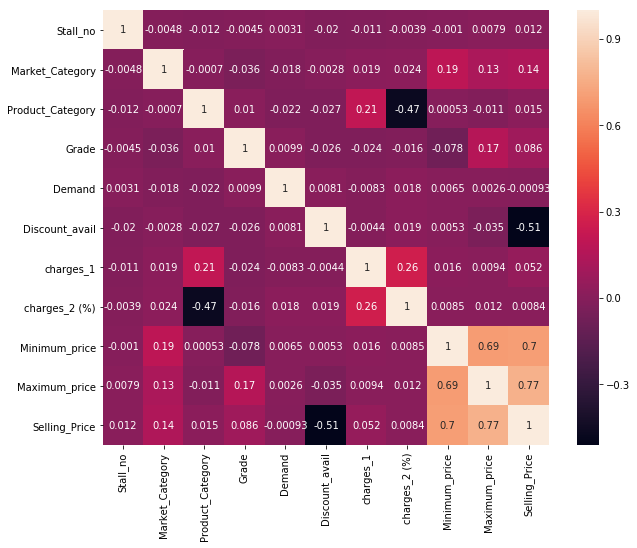

In [30]:
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(),annot=True)
# None of the featuresw have a very high correlation hence can be safely used, we can select features with most corr

In [31]:
# Selcted Columns
selcol = ['Market_Category','Grade','Discount_avail','charges_1','Minimum_price','Maximum_price','charges_1','charges_2 (%)']

In [10]:
xtrain, xtest , ytrain, ytest = train_test_split(train[selcol],train.Selling_Price)

In [32]:
rfr = RandomForestRegressor(random_state  = 0,n_estimators= 200,n_jobs=-1)

In [33]:
rfr.fit(train[selcol],train.Selling_Price)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
yp = rfr.predict(xtest)
mean_squared_error(ytest,yp)

20527.1246495498

In [41]:
yf = rfr.predict(test.drop('Product_id',axis=1)[selcol])

In [39]:
test = test.drop(['instock_date','Customer_name'],axis=1)
test = cat2num(fillmedian(test))
test.dropna(inplace = True)

In [40]:
test.columns

Index(['Product_id', 'Stall_no', 'Market_Category', 'Loyalty_customer',
       'Product_Category', 'Grade', 'Demand', 'Discount_avail', 'charges_1',
       'charges_2 (%)', 'Minimum_price', 'Maximum_price'],
      dtype='object')

In [42]:
final = pd.DataFrame((zip(test['Product_id'],yf)),columns=['Product_id','Selling_Price'])

In [43]:
final.to_csv('subf11.csv',index= False)